## Разработка программы распознавания лица с использованием сверточной нейронной сети (CNN)

По аналогии с форматом Yale Face Database подготовить 10 изображений своего лица.

Выбрать реализацию и обучить сверточную нейронную сеть (CNN) для распознавания в соответствии с вариантом лица человека с маскировкой очками, сбежавшего из-под карантина, в случае его попадания в поле зрения наружной видеокамеры с 10 альтернативными лицами (в том числе изображения из Yale Face Database).

Провести эксперимент по распознаванию лиц с визуализацией результатов.

Попробовать несколько вариантов архитектур CNN. Выбрать лучшую архитектуру как минимум из 2. 

In [1]:
import cv2
#convert image to gray and save it with the same name
imagename = 'faces/train/Olea/sleepy.jpg'
# Reading the image
img = cv2.imread(imagename,cv2.IMREAD_GRAYSCALE)
# Saving the image 
cv2.imwrite(imagename, img)

# Showing the image
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from os.path import join
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt

train = join("faces/train")
test = join("faces/test")

img_width = 64
img_height = 64
epochs = 30
steps_per_epoch = 125
batch_size = 16


# Augmentation setup for training
datagen = ImageDataGenerator(
    rotation_range=40, #a value in degrees (0-180), a range within which to randomly rotate pictures
    width_shift_range=0.2, #ranges (as a fraction of total width or height) within which to randomly translate pictures vertically
    height_shift_range=0.2, #or horizontally
    # Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our 
    # models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor
    rescale=1./255, #a value by which we will multiply the data before any other processing
    shear_range=0.2, #for randomly applying shearing transformations
    zoom_range=0.2, #for randomly zooming inside pictures
    horizontal_flip=True, #for randomly flipping half of the images horizontally
    fill_mode='nearest') #the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

X_train = datagen.flow_from_directory(
    train, # training directory
    target_size=(img_width, img_height), # images will be resized
    batch_size = batch_size, # how many augmented images we need
    class_mode='binary') # two classes are required to find,

testDatagen = ImageDataGenerator(rescale=1./255)
X_test = testDatagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    class_mode = 'binary')

Using TensorFlow backend.
C:\Users\OlgaCeban\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\OlgaCeban\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\OlgaCeban\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\OlgaC

Found 20 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [3]:
model = Sequential()
model.add(Conv2D(32,(5,5),activation='relu', 
                                 input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

model.summary() #summary

model.compile(optimizer='sgd',
              loss='mse', 
              metrics=['accuracy'])

# train model
model.fit(
    X_train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1) #verbose=1 will show you an animated progress bar

print('First model')

predictions = model.predict(X_test)

img, label = zip(*(X_test[i] for i in range(len(X_test))))
img_value, label_value = np.vstack(img), (np.vstack(label))

print('labels = {}, pred = {}'.format(label_value.reshape(-1),predictions.reshape(-1)))
print('\n Evaluate on test data')
results = model.evaluate(X_test)
print('test loss, test acc:', results)

iterator = 1
name = ""
for img, lbl, prd in zip(img_value,label_value.reshape(-1),predictions.reshape(-1)):
    if prd > 0.5:
        name = "Olea"
    else:
        name = "Subject03"
    plt.imshow(img, cmap='gray')
    plt.title(" {}\n predicted {}".format(name, prd))
    iterator += 1
    plt.show()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10817     
Total params: 64,513
Trainable params: 64,513
Non-trainable params: 0
_________________________________________________

In [4]:
# CNN V2

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', name='conv0',
                  input_shape=(img_width, img_height, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool0'))
model2.add(Conv2D(32, (3, 3), activation='relu', name='rl0'))
model2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool1'))
model2.add(Conv2D(64, (3, 3), activation='relu', name='rl1'))
model2.add(MaxPooling2D(pool_size=(2, 2), name='max_pool2'))
model2.add(Flatten()) # converts our 3D feature maps to 1D feature vectors
model2.add(Dense(64, activation='relu', name='rl2'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='softmax', name='sigmoid'))
# model2.add(Activation('sigmoid'))

model2.summary() #summary

model2.compile(optimizer='sgd',
              loss='mse', 
              metrics=['accuracy'])

# train model
model2.fit(
    X_train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    verbose=1)

print('Second model')

predictions = model2.predict(X_test)

img, label = zip(*(X_test[i] for i in range(len(X_test))))
img_value, label_value = np.vstack(img), (np.vstack(label))

print('labels = {}, pred = {}'.format(label_value.reshape(-1),predictions.reshape(-1)))
print('\n Evaluate on test data')
results = model2.evaluate(X_test)
print('test loss, test acc:', results)

iterator = 1
name = ""
for img, lbl, prd in zip(img_value,label_value.reshape(-1),predictions.reshape(-1)):
    if prd > 0.5:
        name = "Olea"
    else:
        name = "Subject03"
    plt.imshow(img, cmap='gray')
    plt.title(" {}\n predicted {}".format(name, prd))
    iterator += 1
    plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 62, 62, 32)        896       
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 31, 31, 32)        0         
_________________________________________________________________
rl0 (Conv2D)                 (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
rl1 (Conv2D)                 (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [5]:
# CNN v3
model3 = Sequential()

model3.add(Conv2D(32, (5, 5), strides = (1,1), name = 'conv0', input_shape = (img_width, img_height, 3)))
model3.add(BatchNormalization(axis = 3, name = 'bn0'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2), name='max_pool'))
model3.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model3.add(Activation('relu'))
model3.add(AveragePooling2D((3, 3), name='avg_pool'))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(300, activation="relu", name='rl'))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation='sigmoid', name='sigm'))

model3.summary() # summary

model3.compile(optimizer='sgd',
              loss='mse', 
              metrics=['accuracy'])

# train model
model3.fit(
    X_train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1) #verbose=1 will show you an animated progress bar


print('Third model')

predictions = model3.predict(X_test)

img, label = zip(*(X_test[i] for i in range(len(X_test))))
img_value, label_value = np.vstack(img), (np.vstack(label))

print('labels = {}, pred = {}'.format(label_value.reshape(-1),predictions.reshape(-1)))
print('\n Evaluate on test data')
results = model3.evaluate(X_test)
print('test loss, test acc:', results)

iterator = 1
name = ""
for img, lbl, prd in zip(img_value,label_value.reshape(-1),predictions.reshape(-1)):
    if prd > 0.5:
        name = "Olea"
    else:
        name = "Subject03"
    plt.imshow(img, cmap='gray')
    plt.title(" {}\n predicted {}".format(name, prd))
    iterator += 1
    plt.show()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 60, 60, 32)        2432      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 60, 60, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 9, 9, 64)        

First model
labels = [0. 1.], pred = [1. 1.]

 Evaluate on test data
1/1 [==============================] - 0s 13ms/step
test loss, test acc: [0.5, 0.5]


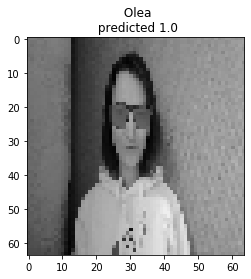

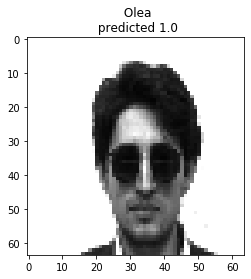

Second model
labels = [0. 1.], pred = [1. 1.]

 Evaluate on test data
1/1 [==============================] - 0s 10ms/step
test loss, test acc: [0.5, 0.5]


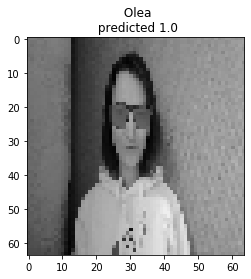

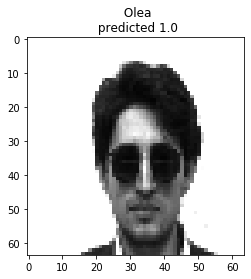

Third model
labels = [0. 1.], pred = [0.00341631 0.993399  ]

 Evaluate on test data
1/1 [==============================] - 0s 17ms/step
test loss, test acc: [2.7622032575891353e-05, 1.0]


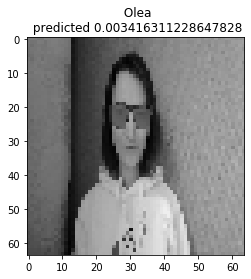

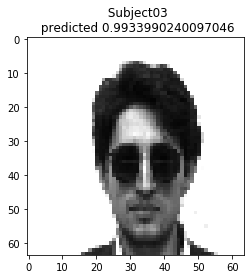

In [8]:
print('First model')

predictions = model.predict(X_test)

img, label = zip(*(X_test[i] for i in range(len(X_test))))
img_value, label_value = np.vstack(img), (np.vstack(label))

print('labels = {}, pred = {}'.format(label_value.reshape(-1),predictions.reshape(-1)))
print('\n Evaluate on test data')
results = model.evaluate(X_test)
print('test loss, test acc:', results)

iterator = 1
name = ""
for img, lbl, prd in zip(img_value,label_value.reshape(-1),predictions.reshape(-1)):
    if prd > 0.5:
        name = "Olea"
    else:
        name = "Subject03"
    plt.imshow(img, cmap='gray')
    plt.title(" {}\n predicted {}".format(name, prd))
    iterator += 1
    plt.show()
    
    
print('Second model')

predictions = model2.predict(X_test)

img, label = zip(*(X_test[i] for i in range(len(X_test))))
img_value, label_value = np.vstack(img), (np.vstack(label))

print('labels = {}, pred = {}'.format(label_value.reshape(-1),predictions.reshape(-1)))
print('\n Evaluate on test data')
results = model2.evaluate(X_test)
print('test loss, test acc:', results)

iterator = 1
name = ""
for img, lbl, prd in zip(img_value,label_value.reshape(-1),predictions.reshape(-1)):
    if prd > 0.5:
        name = "Olea"
    else:
        name = "Subject03"
    plt.imshow(img, cmap='gray')
    plt.title(" {}\n predicted {}".format(name, prd))
    iterator += 1
    plt.show()
    
    
print('Third model')

predictions = model3.predict(X_test)

img, label = zip(*(X_test[i] for i in range(len(X_test))))
img_value, label_value = np.vstack(img), (np.vstack(label))

print('labels = {}, pred = {}'.format(label_value.reshape(-1),predictions.reshape(-1)))
print('\n Evaluate on test data')
results = model3.evaluate(X_test)
print('test loss, test acc:', results)

iterator = 1
name = ""
for img, lbl, prd in zip(img_value,label_value.reshape(-1),predictions.reshape(-1)):
    if prd > 0.5:
        name = "Subject03"
    else:
        name = "Olea"
    plt.imshow(img, cmap='gray')
    plt.title(" {}\n predicted {}".format(name, prd))
    iterator += 1
    plt.show()